## Explain Your Model with the SHAP Values

* Please read [Explain your model with the SHAP values](https://towardsdatascience.com/explain-your-model-with-the-shap-values-bc36aac4de3d)

In [1]:
import pandas as pd
import numpy as np
import plotly
np.random.seed(0)
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv('/winequality-red.csv') # ,sep=';')

In [3]:
df.shape

(1599, 12)

In [4]:
df.columns
df['quality'] = df['quality'].astype(int)

In [5]:
df.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5


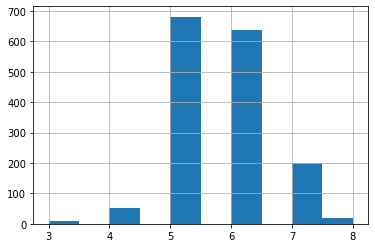

In [6]:
df['quality'].hist()

In [7]:
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.ensemble import RandomForestRegressor

Y = df['quality']
X =  df[['fixed acidity', 'volatile acidity', 'citric acid', 'residual sugar',
       'chlorides', 'free sulfur dioxide', 'total sulfur dioxide', 'density',
       'pH', 'sulphates', 'alcohol']]


In [8]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.2)

In [9]:
model = RandomForestRegressor(max_depth=6, random_state=0, n_estimators=10)
model.fit(X_train, Y_train)  
print(model.feature_importances_)

[0.02771784 0.14608857 0.0098873  0.03979135 0.03834853 0.02349039
 0.07114265 0.01940386 0.04327445 0.20548462 0.37537044]


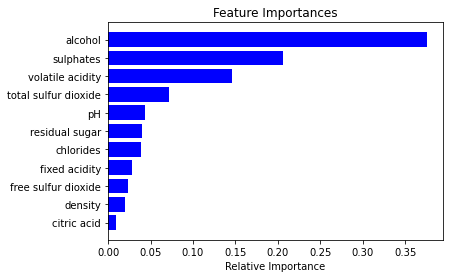

In [10]:
importances = model.feature_importances_
indices = np.argsort(importances)

features = X_train.columns
plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='b', align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()

In [11]:
import shap

In [12]:
shap_values = shap.TreeExplainer(model).shap_values(X_train)

Setting feature_perturbation = "tree_path_dependent" because no background data was given.


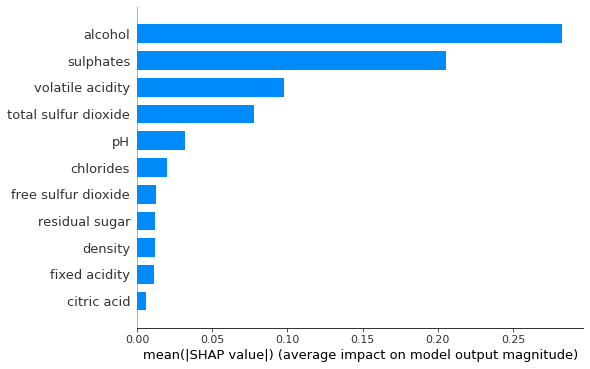

In [13]:
shap.summary_plot(shap_values, X_train, plot_type="bar")

Can the above variable importance plot show the directions between the features and the target variable? Yes, that's the power of the Shap value plot as shown below. This plot is made of many dots. Each dot has three characteristics. The graph below plots the SHAP values of every feature for every sample. It shorts features by the total of absolute SHAP values over all samples. The color represents the feature value (red high, blue low). 

* The vertical location shows the feature importance.
* The horizontal location shows whether the effect of that value caused a higher or lower prediction.
* Color shows whether that feature was high or low for that observation

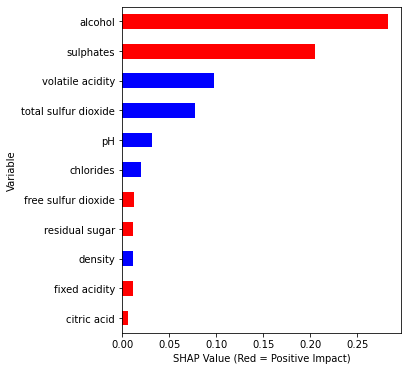

In [14]:
def ABS_SHAP(df_shap,df):
    #import matplotlib as plt
    # Make a copy of the input data
    shap_v = pd.DataFrame(df_shap)
    feature_list = df.columns
    shap_v.columns = feature_list
    df_v = df.copy().reset_index().drop('index',axis=1)
    
    # Determine the correlation in order to plot with different colors
    corr_list = list()
    for i in feature_list:
        b = np.corrcoef(shap_v[i],df_v[i])[1][0]
        corr_list.append(b)
    corr_df = pd.concat([pd.Series(feature_list),pd.Series(corr_list)],axis=1).fillna(0)
    # Make a data frame. Column 1 is the feature, and Column 2 is the correlation coefficient
    corr_df.columns  = ['Variable','Corr']
    corr_df['Sign'] = np.where(corr_df['Corr']>0,'red','blue')
    
    # Plot it
    shap_abs = np.abs(shap_v)
    k=pd.DataFrame(shap_abs.mean()).reset_index()
    k.columns = ['Variable','SHAP_abs']
    k2 = k.merge(corr_df,left_on = 'Variable',right_on='Variable',how='inner')
    k2 = k2.sort_values(by='SHAP_abs',ascending = True)
    colorlist = k2['Sign']
    ax = k2.plot.barh(x='Variable',y='SHAP_abs',color = colorlist, figsize=(5,6),legend=False)
    ax.set_xlabel("SHAP Value (Red = Positive Impact)")
    
ABS_SHAP(shap_values,X_train)

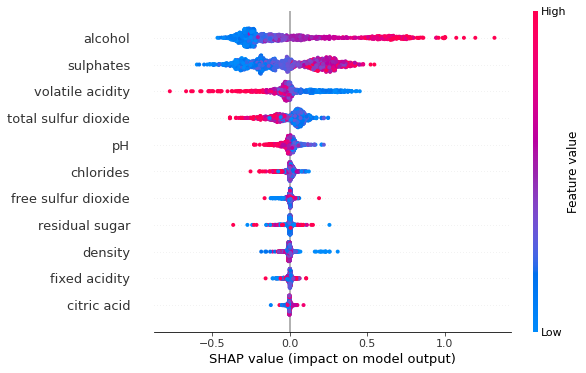

In [15]:
shap.summary_plot(shap_values, X_train)

We can describe the model. A high quality rating of wine is associated with the following characteristics:
* High alcohol content 
* High sulphates 
* Low volatile acidity 
* Low total sulfuer dioxide 
* Low pH 
* Low chlorides
* Low citric acid
* Low density
* High fixed acidity content
* High free sulfur dioxide
* High residual sugar

To understand how a single feature effects the output of the model we can plot the SHAP value of that feature vs. the value of the feature for all the examples in a dataset. Since SHAP values represent a feature's responsibility for a change in the model output, the plot below represents the change in predicted house price as RM (the average number of rooms per house in an area) changes. Vertical dispersion at a single value of RM represents interaction effects with other features. To help reveal these interactions dependence_plot automatically selects another feature for coloring. In this case coloring by RAD (index of accessibility to radial highways) highlights that the average number of rooms per house has less impact on home price for areas with a high RAD value.

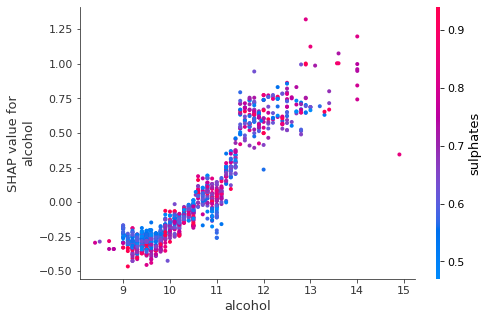

In [16]:
# we pass "Age" instead of an index because dependence_plot() will find it in X's column names for us
# Systolic BP was automatically chosen for coloring based on a potential interaction to check that 
# the interaction is really in the model see SHAP interaction values below
shap.dependence_plot("alcohol", shap_values, X_train)

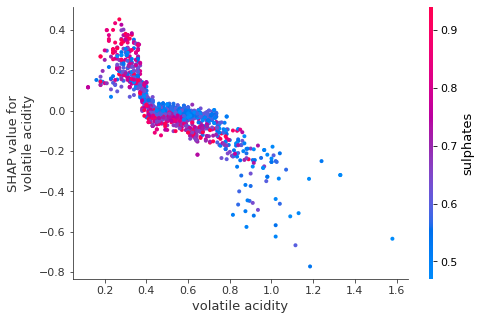

In [17]:
# we pass display_features so we get text display values for sex
shap.dependence_plot("volatile acidity", shap_values, X_train)

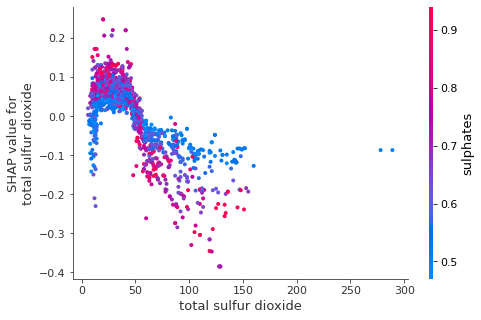

In [18]:
shap.dependence_plot("total sulfur dioxide", shap_values, X_train, show=False)
plt.show()

Setting feature_perturbation = "tree_path_dependent" because no background data was given.


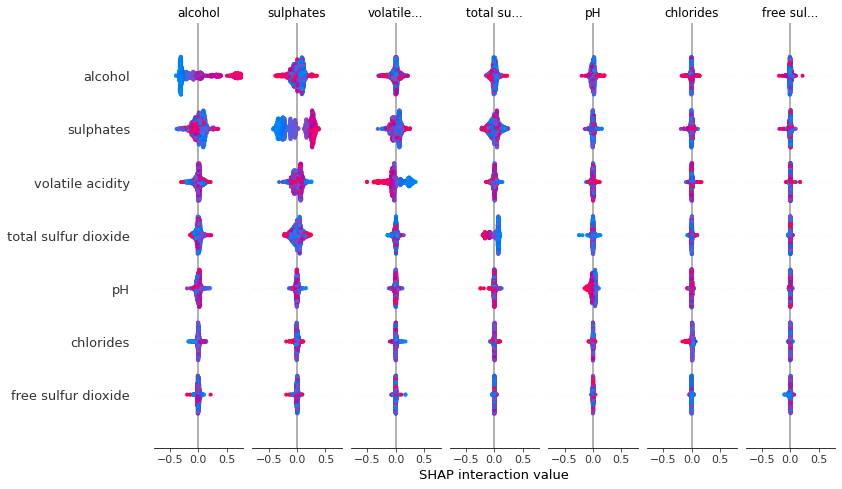

In [19]:
# takes a couple minutes since SHAP interaction values take a factor of 2 * # features
# more time than SHAP values to compute, since this is just an example we only explain
# the first 2,000 people in order to run quicker
shap_interaction_values = shap.TreeExplainer(model).shap_interaction_values(X_train.iloc[:2000,:])

shap.summary_plot(shap_interaction_values, X_train.iloc[:2000,:])

In [20]:
X_output = X_test.copy()
X_output.loc[:,'predict'] = np.round(model.predict(X_output),2)

random_picks = np.arange(1,330,50)
S = X_output.iloc[random_picks]
S

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,predict
1032,8.1,0.820,0.00,4.1,0.095,5.0,14.0,0.99854,3.36,0.53,9.6,4.50
34,5.2,0.320,0.25,1.8,0.103,13.0,50.0,0.99570,3.38,0.55,9.2,5.35
1508,7.1,0.270,0.60,2.1,0.074,17.0,25.0,0.99814,3.38,0.72,10.6,6.26
1479,8.2,0.280,0.60,3.0,0.104,10.0,22.0,0.99828,3.39,0.68,10.6,5.93
866,6.8,0.490,0.22,2.3,0.071,13.0,24.0,0.99438,3.41,0.83,11.3,6.33
1519,6.6,0.700,0.08,2.6,0.106,14.0,27.0,0.99665,3.44,0.58,10.2,5.47
1193,6.4,0.885,0.00,2.3,0.166,6.0,12.0,0.99551,3.56,0.51,10.8,4.51


In [21]:
shap.initjs()

In [22]:
def shap_plot(j):
    explainerModel = shap.TreeExplainer(model)
    shap_values_Model = explainerModel.shap_values(S)
    p = shap.force_plot(explainerModel.expected_value, shap_values_Model[j], S.iloc[[j]])
    return(p)

In [23]:
X_train.mean()

fixed acidity            8.337373
volatile acidity         0.530000
citric acid              0.272181
residual sugar           2.553167
chlorides                0.087024
free sulfur dioxide     16.032838
total sulfur dioxide    47.114152
density                  0.996757
pH                       3.309828
sulphates                0.659077
alcohol                 10.413995
dtype: float64

In [24]:
Y_test.mean()

5.59375

In [25]:
shap_plot(0)

Setting feature_perturbation = "tree_path_dependent" because no background data was given.


* Output value: is the prediction for that observation
* Base value: The [original paper](http://papers.nips.cc/paper/7062-a-unified-approach-to-interpreting-model-predictions.pdf) explains that the base value E(y_hat) is "the value that would be predicted if we did not know any features for the current output." In other words, it is the mean prediction, or mean(yhat). So the mean prediction of Y_test is 5.62.
* Features: The above explanation shows features that contributes to push the final prediction away from the base value.
* Red/blue: Those features that push the prediction higher (to the right) are shown in red, and those pushing the prediction lower are in blue. 
* Alcohol: has positive impact on the quality rating. The alcohol of this wine is 11.8 which is higher than the average value 10.41. So it pushes the prediction to the right.
* pH: has a negative impact on the quality rating. A lower than the average pH (=3.26 <3.30) drives the prediction to the right.
* Sulphates: is positively related to the quality rating. A lower than the average Sulphates (= 0.64 < 0.65) pushes the prediction to the left.

In [26]:
shap_plot(1)

In [27]:
shap_plot(2)

In [28]:
shap_plot(3)

In [29]:
shap_plot(4)

In [30]:
fig = shap_plot(4)

In [31]:
fig

### The SHAP Works for Binary Target as Well

In [34]:
# Suppose the target is a binary variable
df['quality_bin'] = np.where(df['quality'].astype(int)>6,1,0)

[0.06068552 0.09181401 0.0426238  0.04684194 0.0637269  0.03552689
 0.08485588 0.03511305 0.04465817 0.20089978 0.29325405]


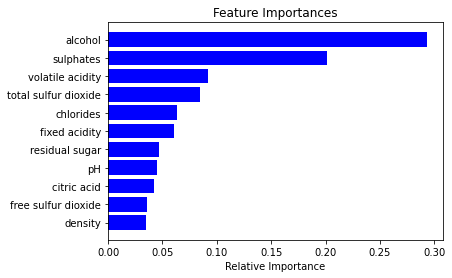

In [35]:
Y = df['quality_bin']
X =  df[['fixed acidity', 'volatile acidity', 'citric acid', 'residual sugar',
       'chlorides', 'free sulfur dioxide', 'total sulfur dioxide', 'density',
       'pH', 'sulphates', 'alcohol']]
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.2)

model = RandomForestRegressor(max_depth=6, random_state=0, n_estimators=10)
model.fit(X_train, Y_train)  
print(model.feature_importances_)

importances = model.feature_importances_
indices = np.argsort(importances)

features = X_train.columns
plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='b', align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()

In [36]:
import shap
shap_values = shap.TreeExplainer(model).shap_values(X_train)

Setting feature_perturbation = "tree_path_dependent" because no background data was given.


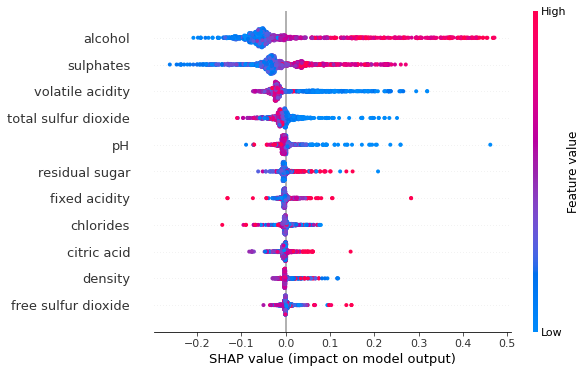

In [37]:
shap.summary_plot(shap_values, X_train)